# Feature Selection Example (not done)
Coming soon.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster
from sklearn.linear_model import Lasso
from config import model_params, dynamic_tuning, patience, grids

pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

In [2]:
sns.set(rc={'figure.figsize':(12,8)})

In [3]:
def prepare_fcst(
    f,
    test_length=.1,
    fcst_length=1
):
    f.generate_future_dates(fcst_length)
    f.set_test_length(test_length)
    f.set_validation_length(120)
    f.add_seasonal_regressors('month','quarter',raw=False,sincos=True)
    f.set_validation_metric('mae')
    for i in np.arange(12,289,12): # 12-month cycles from 12 to 288 months
        f.add_cycle(i)
    f.add_ar_terms(120) # AR 1-120
    f.add_AR_terms((20,12)) # seasonal AR up to 20 years, spaced one year apart
    f.add_time_trend()
    f.add_seasonal_regressors('year')
    return f

def sort_pfi_df(df):
    df['weight'] = np.abs(df['weight'])
    return df.sort_values(['weight','std'],ascending=False)

def reduce_vars(
    f,
    features,
    call_me,
    monitor="ValidationMetricValue", # don't use R2 without a proper modification
    patience=5,
    rebuild_fi_df=True,
):
    """ reduces variables one-by-one using evaluated feature importance, reducing the worst-performing variables first
    
    Args:
        f (Forecaster): the Forecaster object to evaluate models with.
        features (list-like): the list of variables to try sorted from most-to-least important.
        call_me (str): the name of the resulting reduced model stored in f.
        patience (int): the number of iterations to wait before giving up.
        monitor (str): one of Forecaster._determine_best_by_.
            the metric to monitor to see if improvements are being made.
            do not use R2 unless you modify this function appropriately.
        rebuild_fi_df (bool): whether to recreate the permutated feature scores after each model eval.
            if not using pfi, set this to False.
    
    Returns:
        None
    """
    init_error = f.history[f.estimator][monitor]
    hp = f.history[f.estimator]['HyperParams']
    best_error = init_error
    print(f'beginning {monitor}: {init_error}')
    
    grid = grids[f.estimator]
    dropped = []
    errors = [init_error]
    
    i = 0
    while len(dropped) < (len(f.get_regressor_names()) - 1):
        print('dropping {}'.format(features[-1]))
        dropped.append(features[-1])
        features = features[:-1]
        grid['Xvars'] = [features]
        f.ingest_grid(grid)
        f.tune(dynamic_tuning=dynamic_tuning)
        f.auto_forecast(
            **model_params,
            call_me = call_me,
        )
        new_error = f.history[call_me][monitor]
        errors.append(new_error)
        
        if rebuild_fi_df:
            f.save_feature_importance()
            fi_df = f.export_feature_importance(call_me)
            fi_df = sort_pfi_df(fi_df)
            features = fi_df.index.to_list()
        
        if best_error <= new_error: # no reduction
            i+=1
        else: # reduction
            best_error = new_error 
            print(f'error reduced to {best_error}')
            i = 0
        
        if i == patience:
            break
   
    if len(dropped) == patience:
        f.pop(call_me)
        print('feature reduction yielded no results')
    else:
        final_Xvars = f.history[call_me]['Xvars'] + dropped[-patience:]
        final_hp = f.history[call_me]['HyperParams']
        f.manual_forecast(
            **model_params,
            **final_hp,
            Xvars = final_Xvars,
            call_me = call_me,
        )
        print(f'last {patience} vars added back')
        print(f'final model trained with {len(final_Xvars)} vars')
        print(f'final {monitor}: {f.history[call_me][monitor]}')
    return dropped, errors

def plot_errors(dropped,errors):
    _, ax = plt.subplots()
    sns.lineplot(
        x=np.arange(0,len(dropped)+1,1),
        y=errors,
        label='actual error',
    )
    sns.regplot(
        x=np.arange(0,len(dropped)+1,1),
        y=errors,
        ci=None,
        color=sns.color_palette()[1],
        order=2,
    )
    plt.xlabel('dropped Xvars')
    plt.ylabel('error')
    return ax
    
def export_results(f):
    results = f.export('model_summaries',determine_best_by='TestSetMAE')
    results['N_Xvars'] = results['Xvars'].apply(lambda x: len(x))
    return results[
        [
            'ModelNickname',
            'TestSetMAE',
            'InSampleMAE',
            'TestSetR2',
            'InSampleR2',
            'ValidationMetric',
            'ValidationMetricValue',
            'HyperParams',
            'N_Xvars'
        ]
    ]

In [5]:
df = pd.read_csv('Sunspots.csv',index_col=0,names=['Date','Target'],header=0)
f = Forecaster(y=df['Target'],current_dates=df['Date'])

In [6]:
prepare_fcst(f)

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=1
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'cycle12sin', 'cycle12cos', 'cycle24sin', 'cycle24cos', 'cycle36sin', 'cycle36cos', 'cycle48sin', 'cycle48cos', 'cycle60sin', 'cycle60cos', 'cycle72sin', 'cycle72cos', 'cycle84sin', 'cycle84cos', 'cycle96sin', 'cycle96cos', 'cycle108sin', 'cycle108cos', 'cycle120sin', 'cycle120cos', 'cycle132sin', 'cycle132cos', 'cycle144sin', 'cycle144cos', 'cycle156sin', 'cycle156cos', 'cycle168sin', 'cycle168cos', 'cycle180sin', 'cycle180cos', 'cycle192sin', 'cycle192cos', 'cycle204sin', 'cycle204cos', 'cycle216sin', 'cycle216cos', 'cycle228sin', 'cycle228cos', 'cycle240sin', 'cycle240cos', 'cycle252sin', 'cycle252cos', 'cycle264sin', 'cycle264cos', 'cycle276sin', 'cycle276cos', 'cycle288sin', 'cycle288cos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10',

In [7]:
print('starting out with {} variables'.format(len(f.get_regressor_names())))

starting out with 184 variables


## Reducing with Lasso

In [8]:
f.add_sklearn_estimator(Lasso,'lasso')
f.set_estimator('lasso')
f.ingest_grid(grids['lasso'])
f.tune(dynamic_tuning=dynamic_tuning)
f.auto_forecast(**model_params)
f.save_feature_importance()

In [9]:
coef_fi_lasso = pd.DataFrame(
    {x: [np.abs(co)] for x, co in zip(f.history['lasso']['Xvars'],f.regr.coef_)},
    index = ['feature'],
).T.sort_values('feature',ascending=False)
coef_fi_lasso.tail()

feature
AR50   0.0000
AR49   0.0000
AR48   0.0000
AR47   0.0000
year   0.0000

In [10]:
print('lasso model reduced {} variable coefficients to 0, leaving {} variables with effects in the model'.format(
    coef_fi_lasso.loc[coef_fi_lasso['feature'] == 0].shape[0],
    coef_fi_lasso.loc[coef_fi_lasso['feature'] != 0].shape[0],
))

lasso model reduced 78 variable coefficients to 0, leaving 106 variables with effects in the model


In [11]:
pfi_lasso = f.export_feature_importance('lasso')
pfi_lasso = sort_pfi_df(pfi_lasso)
pfi_lasso.tail()

weight    std
feature               
AR75     0.0000 0.0000
AR77     0.0000 0.0000
AR168    0.0000 0.0000
AR144    0.0000 0.0000
AR99     0.0000 0.0000

beginning ValidationMetricValue: 20.87019235103222
dropping year
dropping AR47
error reduced to 20.867806070924154
dropping AR48
dropping AR49
dropping AR50
dropping AR51
dropping AR54
dropping AR55
dropping AR56
last 7 vars added back
final model trained with 182 vars
final ValidationMetricValue: 20.867828464154748


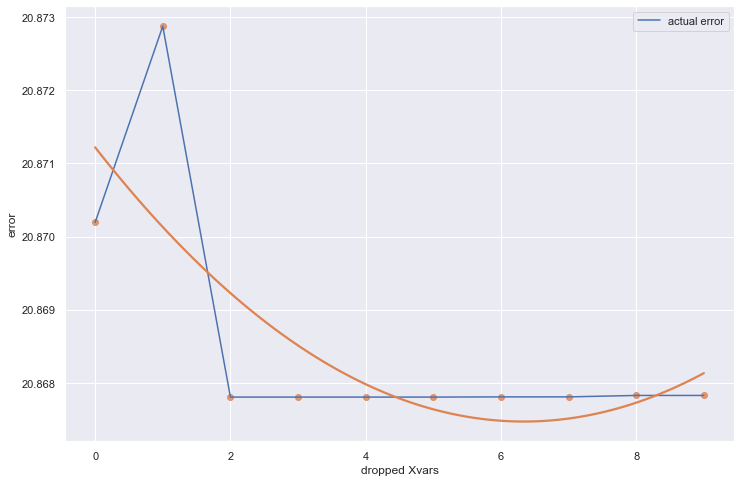

In [12]:
dropped, errors = reduce_vars(
    f,
    coef_fi_lasso.index.to_list(),
    'lasso_coef_reduced',
    patience=patience,
    rebuild_fi_df=False,
)

plot_errors(dropped,errors)
plt.show()

beginning ValidationMetricValue: 20.87019235103222
dropping AR99
dropping AR30
dropping AR97
dropping AR19
dropping AR77
dropping AR85
dropping AR109
error reduced to 20.865825126420486
dropping AR89
dropping AR83
dropping AR82
dropping cycle276cos
dropping AR100
error reduced to 20.865488453494848
dropping AR86
dropping AR61
dropping AR74
dropping AR60
dropping AR17
dropping AR180
dropping cycle240sin
last 7 vars added back
final model trained with 172 vars
final ValidationMetricValue: 20.86593679976401


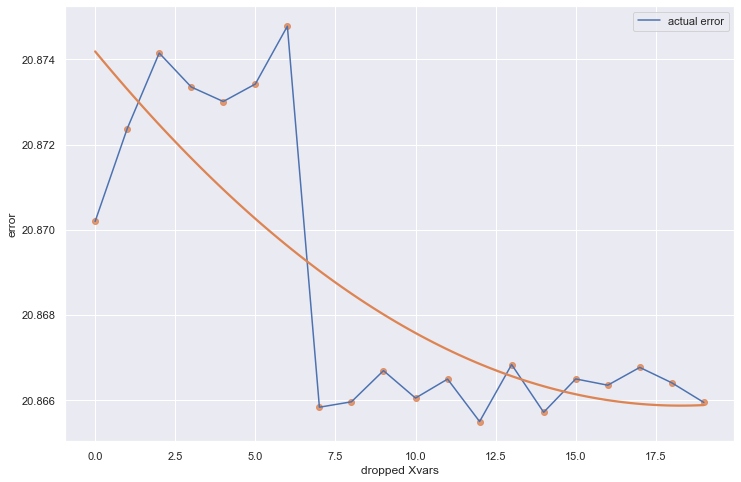

In [13]:
dropped, errors = reduce_vars(
    f,
    pfi_lasso.index.to_list(),
    'lasso_pfi_reduced',
    patience=patience,
)

plot_errors(dropped,errors)
plt.show()

In [14]:
export_results(f)

ModelNickname  TestSetMAE  InSampleMAE  TestSetR2  InSampleR2  \
0   lasso_pfi_reduced     13.6450      17.3370     0.8880      0.8818   
1               lasso     13.6452      17.3371     0.8880      0.8818   
2  lasso_coef_reduced     13.6488      17.3361     0.8880      0.8818   

  ValidationMetric  ValidationMetricValue       HyperParams  N_Xvars  
0              mae                20.8659  {'alpha': 0.025}      172  
1              mae                20.8702  {'alpha': 0.025}      184  
2              mae                20.8678  {'alpha': 0.025}      182

## Reducing with GBT

In [15]:
f.set_estimator('gbt')
f.ingest_grid(grids['gbt'])
f.tune(dynamic_tuning=dynamic_tuning)
f.auto_forecast(**model_params)
f.save_feature_importance()

In [16]:
gini_fi_gbt = pd.DataFrame(
    {x: [fi] for x, fi in zip(f.history['gbt']['Xvars'],f.regr.feature_importances_)},
    index = ['feature'],
).T.sort_values('feature',ascending=False)
gini_fi_gbt.tail()

feature
cycle24cos   0.0001
monthsin     0.0001
cycle12cos   0.0000
quartersin   0.0000
quartercos   0.0000

In [17]:
pfi_gbt = f.export_feature_importance('gbt')
pfi_gbt = sort_pfi_df(pfi_gbt)
pfi_gbt.tail()

weight    std
feature                  
cycle12cos  0.0003 0.0006
quartercos  0.0002 0.0001
cycle72cos  0.0001 0.0004
cycle60cos  0.0000 0.0010
monthsin    0.0000 0.0007

beginning ValidationMetricValue: 33.73889865385461
dropping quartercos
error reduced to 28.96529392981511
dropping quartersin
error reduced to 22.428855847843355
dropping cycle12cos
dropping monthsin
dropping cycle24cos
dropping monthcos
dropping cycle24sin
dropping cycle72cos
dropping cycle60cos
last 7 vars added back
final model trained with 182 vars
final ValidationMetricValue: 22.836695837872977


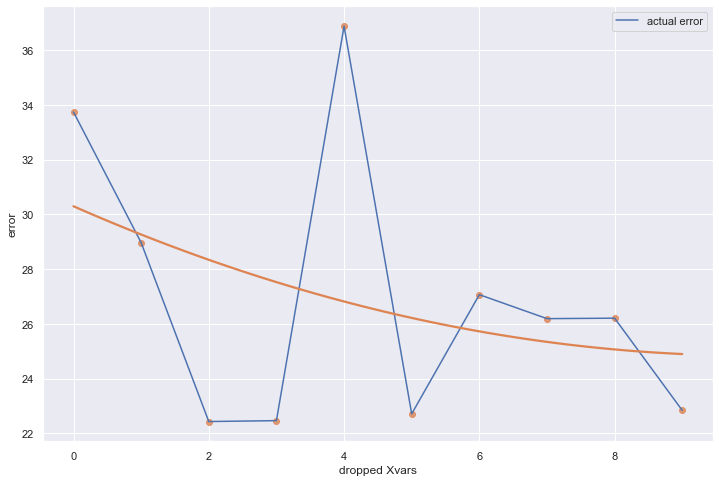

In [18]:
dropped, errors = reduce_vars(
    f,
    gini_fi_gbt.index.to_list(),
    'gbt_gini_reduced',
    patience=patience,
    rebuild_fi_df=False,
)

plot_errors(dropped,errors)
plt.show()

beginning ValidationMetricValue: 33.73889865385461
dropping monthsin
error reduced to 23.539416527106372
dropping quartersin
dropping monthcos
dropping quartercos
dropping cycle48cos
error reduced to 23.00441486929589
dropping cycle48sin
dropping cycle36cos
dropping AR101
dropping cycle12cos
dropping cycle72cos
dropping cycle24sin
dropping cycle24cos
last 7 vars added back
final model trained with 179 vars
final ValidationMetricValue: 32.86482008255432


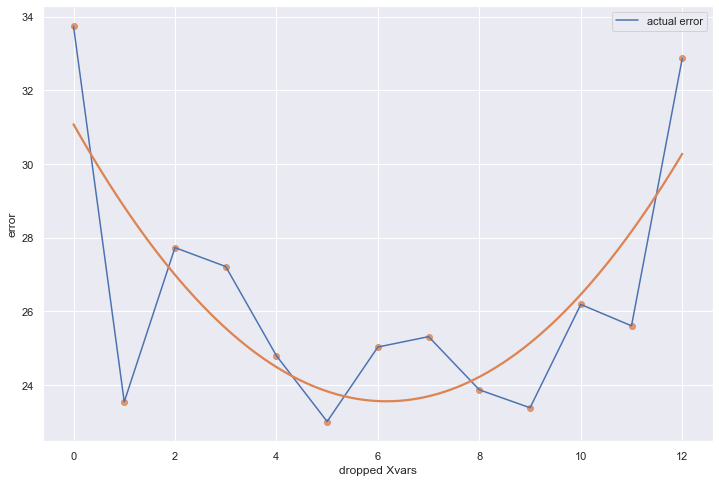

In [19]:
dropped, errors = reduce_vars(
    f,
    pfi_gbt.index.to_list(),
    'gbt_pfi_reduced',
    patience=patience,
)

plot_errors(dropped,errors)
plt.show()

In [20]:
export_results(f)

ModelNickname  TestSetMAE  InSampleMAE  TestSetR2  InSampleR2  \
0   lasso_pfi_reduced     13.6450      17.3370     0.8880      0.8818   
1               lasso     13.6452      17.3371     0.8880      0.8818   
2  lasso_coef_reduced     13.6488      17.3361     0.8880      0.8818   
3     gbt_pfi_reduced     16.6955       0.7651     0.8357      0.9998   
4    gbt_gini_reduced     16.8580       0.7849     0.8437      0.9998   
5                 gbt     16.8594       0.7917     0.8444      0.9998   

  ValidationMetric  ValidationMetricValue  \
0              mae                20.8659   
1              mae                20.8702   
2              mae                20.8678   
3              mae                32.8648   
4              mae                22.8367   
5              mae                33.7389   

                                         HyperParams  N_Xvars  
0                                   {'alpha': 0.025}      172  
1                                   {'alpha': 0.025}      184  
2                                   {'alpha': 0.025}      182  
3  {'n_estimators': 10000, 'max_depth': 2, 'max_f...      179  
4  {'n_estimators': 10000, 'max_depth': 2, 'max_f...      182  
5  {'n_estimators': 10000, 'max_depth': 2, 'max_f...      184

## Train a third model
- using the full set of vars, the best reduced set from lasso, and the best reduced set from GBT
- see if our reductions generalized well enough to be useful for another estimator

In [21]:
lasso_reduced = coef_fi_lasso.loc[coef_fi_lasso['feature'] != 0].index.to_list()
gbt_reduced = f.history['gbt_pfi_reduced']['Xvars']

In [22]:
f.set_estimator('xgboost')
print('finding optimal hyperparams')
f.ingest_grid(grids['xgboost'])
f.tune()
print('training first model - all xvars')
f.auto_forecast(
    **model_params,
)
print('training second model - lasso xvars only')
f.manual_forecast(
    **model_params,
    **f.best_params,
    Xvars = lasso_reduced,
    call_me = 'xgboost_lasso_reduced',
)
print('training third model - gbt xvars only')
f.manual_forecast(
    **model_params,
    **f.best_params,
    Xvars = gbt_reduced,
    call_me = 'xgboost_gbt_reduced',
)

finding optimal hyperparams
training first model - all xvars
training second model - lasso xvars only
training third model - gbt xvars only


## Benchmark models
- since none of these were dynamically tested, all their metrics represent averages of several 1-step forecast  
- we will use these metrics to decide about which four models performed best  

In [23]:
export_results(f)

ModelNickname  TestSetMAE  InSampleMAE  TestSetR2  InSampleR2  \
0      lasso_pfi_reduced     13.6450      17.3370     0.8880      0.8818   
1                  lasso     13.6452      17.3371     0.8880      0.8818   
2     lasso_coef_reduced     13.6488      17.3361     0.8880      0.8818   
3  xgboost_lasso_reduced     14.4962       0.0003     0.8734      1.0000   
4    xgboost_gbt_reduced     14.5193       0.0003     0.8637      1.0000   
5                xgboost     15.0387       0.0003     0.8562      1.0000   
6        gbt_pfi_reduced     16.6955       0.7651     0.8357      0.9998   
7       gbt_gini_reduced     16.8580       0.7849     0.8437      0.9998   
8                    gbt     16.8594       0.7917     0.8444      0.9998   

  ValidationMetric  ValidationMetricValue  \
0              mae                20.8659   
1              mae                20.8702   
2              mae                20.8678   
3              mae                21.3147   
4              mae                21.3147   
5              mae                21.3147   
6              mae                32.8648   
7              mae                22.8367   
8              mae                33.7389   

                                         HyperParams  N_Xvars  
0                                   {'alpha': 0.025}      172  
1                                   {'alpha': 0.025}      184  
2                                   {'alpha': 0.025}      182  
3  {'n_estimators': 10000, 'subsample': 0.9, 'max...      106  
4  {'n_estimators': 10000, 'subsample': 0.9, 'max...      179  
5  {'n_estimators': 10000, 'subsample': 0.9, 'max...      184  
6  {'n_estimators': 10000, 'max_depth': 2, 'max_f...      179  
7  {'n_estimators': 10000, 'max_depth': 2, 'max_f...      182  
8  {'n_estimators': 10000, 'max_depth': 2, 'max_f...      184

Let's take the best-reduced models from each class, as well as the XGBoost with all variables. The Lasso model reduced with pfi technically did a bit better on the test set, but since it's so close, we will use the first lasso model trained.

In [24]:
best_models = [
    'lasso',
    'xgboost_lasso_reduced',
    'xgboost',
    'gbt_pfi_reduced',
]

These predictions look really good, but it is important to remember that they are one-step forecasts. Later, we will see performance on the test set when the forecasts are dynamically tested. It will look worse but will be more realistic of what results would like if we actually implemented these models.

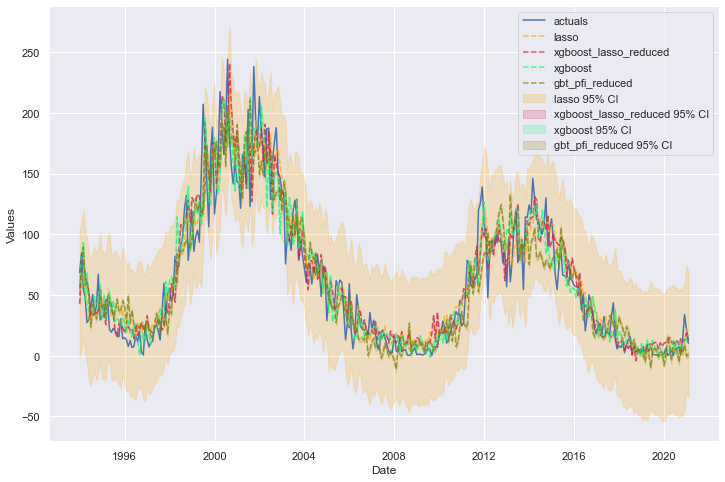

In [25]:
f.plot_test_set(
    ci=True,
    models=best_models,
    include_train=False,
    order_by='LevelTestSetMAE'
)
plt.show()

## Backtest models
- since models were not dynamically tested, we may want to know how they could perform in a dynamic multi-step process
- to do that, we backtest a 120-period forecast (10 years) over the last 25 horizons in the dataset
- the resulting will be an average of 25 120-period mutli-step forecasts, where each prediction is created dynamically
- the best model from this step we can call our actual best model because it is no longer an average of 1-step predictions and will be more likely to generalized to data we have never seen

In [26]:
backtest_metrics = {}

for model in best_models:
    print(f'backtesting {model}')
    f.backtest(
        model,
        n_iter=25,
        fcst_length=120,
    )
    backtest_metrics[model] = f.export_backtest_metrics(model)

backtesting lasso
backtesting xgboost_lasso_reduced
backtesting xgboost
backtesting gbt_pfi_reduced


In [28]:
all_metrics = pd.DataFrame(index=backtest_metrics[model].index)
for model in best_models:
    all_metrics[model] = backtest_metrics[model]['mean']

Here are the metrics from the last model we ran.

In [29]:
backtest_metrics[best_models[-1]]

iter1   iter2   iter3   iter4   iter5   iter6   iter7   iter8   iter9  \
RMSE 34.7385 23.8140 31.2359 30.4650 25.7339 27.0942 24.5874 29.0598 27.3736   
MAE  29.5042 17.2079 26.3514 23.9819 21.9023 21.2287 19.3753 23.1353 22.5329   
R2    0.3199  0.6787  0.4468  0.4738  0.6226  0.5767  0.6488  0.5060  0.5594   
MAPE  9.3095  2.0542  4.9681  5.5927  7.7138  4.2924  2.7346  2.7169  4.9443   

      iter10  ...  iter17  iter18  iter19  iter20  iter21  iter22  iter23  \
RMSE 28.2283  ... 26.8094 21.5852 30.8416 23.9872 28.7163 24.3652 20.3723   
MAE  22.1392  ... 22.4118 16.1009 22.6522 19.7516 24.6778 20.2954 15.8878   
R2    0.5286  ...  0.5565  0.7116  0.4114  0.6431  0.4872  0.6321  0.7438   
MAPE  3.7602  ...  3.7078  1.0722     NaN     NaN     NaN     NaN     NaN   

      iter24  iter25    mean  
RMSE 31.1563 28.8625 27.2671  
MAE  23.9244 23.6434 21.6328  
R2    0.4034  0.4879  0.5465  
MAPE     NaN     NaN  3.7369  

[4 rows x 26 columns]

Here are the average metrics from all models.

In [30]:
all_metrics

lasso  xgboost_lasso_reduced  xgboost  gbt_pfi_reduced
RMSE 41.6702                27.9381  29.2491          27.2671
MAE  34.7486                22.0319  23.3254          21.6328
R2   -0.0399                 0.4992   0.4685           0.5465
MAPE  4.8567                 3.4514   3.1084           3.7369

From backtesting, it was revealed that our actual best model was ....

In [31]:
best_model = 'gbt_pfi_reduced'

## Retrain the best model with dynamic testing
- This way, we can see how the model would have actually performed on the multi-step test set

In [35]:
final_results = f.export('model_summaries')
best_model_estimator = final_results.loc[final_results['ModelNickname'] == best_model,'Estimator'].values[0]
best_model_hyperparams = final_results.loc[final_results['ModelNickname'] == best_model,'HyperParams'].values[0]
best_model_xvars = final_results.loc[final_results['ModelNickname'] == best_model,'Xvars'].values[0]

In [40]:
prepare_fcst(f,test_length=120,fcst_length=120)
f.set_estimator(best_model_estimator)
f.manual_forecast(
    **best_model_hyperparams,
    Xvars=best_model_xvars,
    call_me=best_model+'_dynamically_tested',
)

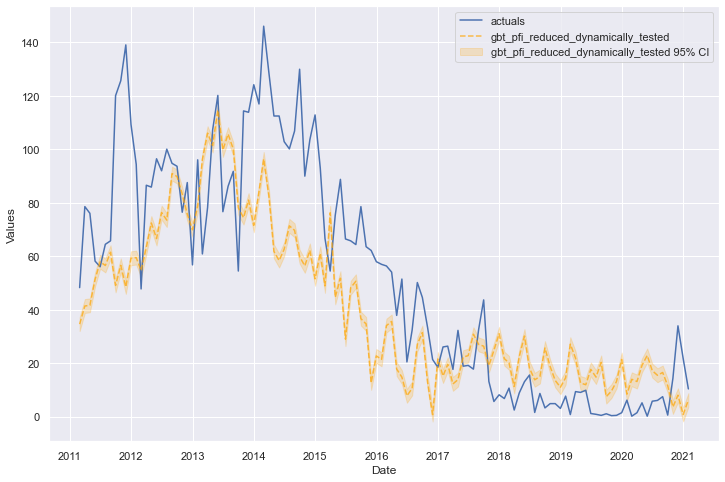

In [41]:
f.plot_test_set(models = best_model+'_dynamically_tested',ci=True,include_train=False)
plt.show()

These 120 periods are much harder to predict when you are not given the actual values along the way. This illustrates the difference between one-step and dynamic multi-step forecasting.

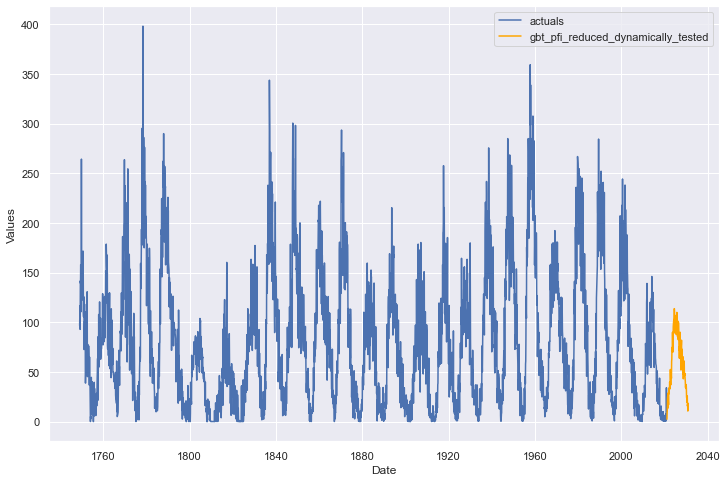

In [42]:
f.plot(models=best_model+'_dynamically_tested')
plt.show()

In [43]:
best_model_results = f.export('model_summaries',models=best_model+'_dynamically_tested')
best_model_results[['TestSetMAE','TestSetR2','InSampleMAE','InSampleR2']]

TestSetMAE  TestSetR2  InSampleMAE  InSampleR2
0     21.7736     0.5732       1.0074      0.9996

## See how often each var was dropped

In [50]:
all_xvars = f.get_regressor_names()
final_dropped = pd.DataFrame({'Var':all_xvars})
for i, v in final_results.iterrows():
    model = v['ModelNickname']
    Xvars = v['Xvars']
    
    if model == 'lasso':
        dropped_vars = coef_fi_lasso.loc[coef_fi_lasso['feature'] == 0].index.to_list()
    else:
        dropped_vars = [x for x in f.get_regressor_names() if x not in Xvars]
    if not dropped_vars:
        continue
    tmp_dropped = pd.DataFrame(
        {
            'Var':dropped_vars,
            f'dropped in {model}':[1]*len(dropped_vars)
        }
    )
    final_dropped = final_dropped.merge(tmp_dropped,on='Var',how='left').fillna(0)
final_dropped['total times dropped'] = final_dropped.iloc[:,1:].sum(axis=1)
final_dropped = final_dropped.loc[final_dropped['total times dropped'] > 0]
final_dropped = final_dropped.sort_values('total times dropped',ascending=False)
final_dropped = final_dropped.reset_index(drop=True)
final_dropped.iloc[:,1:] = final_dropped.iloc[:,1:].astype(int)
final_dropped

Var  dropped in lasso  dropped in lasso_pfi_reduced  \
0    quartercos                 1                             0   
1          year                 1                             0   
2         AR109                 1                             1   
3          AR97                 1                             1   
4          AR85                 1                             1   
5          AR99                 1                             1   
6         AR100                 1                             1   
7          AR30                 1                             1   
8          AR47                 1                             0   
9          AR83                 1                             1   
10         AR82                 1                             1   
11         AR19                 1                             1   
12         AR89                 1                             1   
13  cycle276cos                 1                             1   
14         AR77                 1                             1   
15   quartersin                 0                             0   
16         AR90                 1                             0   
17         AR81                 1                             0   
18         AR79                 1                             0   
19         AR75                 1                             0   
20         AR74                 1                             0   
21         AR72                 1                             0   
22         AR71                 1                             0   
23         AR70                 1                             0   
24         AR86                 1                             0   
25         AR80                 1                             0   
26         AR98                 1                             0   
27         AR91                 1                             0   
28        AR115                 1                             0   
29        AR192                 1                             0   
30        AR180                 1                             0   
31        AR168                 1                             0   
32        AR144                 1                             0   
33        AR119                 1                             0   
34        AR118                 1                             0   
35        AR107                 1                             0   
36         AR93                 1                             0   
37        AR106                 1                             0   
38        AR105                 1                             0   
39        AR103                 1                             0   
40        AR101                 1                             0   
41         AR68                 1                             0   
42         AR95                 1                             0   
43         AR69                 1                             0   
44     monthsin                 0                             0   
45         AR66                 1                             0   
46         AR37                 1                             0   
47         AR33                 1                             0   
48         AR31                 1                             0   
49         AR26                 1                             0   
50         AR22                 1                             0   
51         AR20                 1                             0   
52         AR17                 1                             0   
53         AR13                 1                             0   
54          AR7                 1                             0   
55  cycle276sin                 1                             0   
56  cycle240cos                 1                             0   
57  cycle240sin                 1                             0   
58  cycle204cos                 1                          